#### Import Libraries

In [ ]:
# --- System & Utilities ---
import os                    # File and directory operations
import re                    # Regular expressions for string cleaning
import string                # String operations
import ast                   # Safe evaluation of Python expressions
import random                # Random operations (shuffling, sampling)
import time                  # Time tracking for performance
from collections import Counter  # Count frequencies of tokens

# --- Data Handling ---
import pandas as pd          # DataFrames for structured data
import numpy as np           # Numerical operations and arrays

# --- Natural Language Processing (NLP) ---
import nltk
from nltk.tokenize import word_tokenize           # Tokenize sentences/words
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.corpus import stopwords, wordnet        # Common stopwords and WordNet
from nltk.stem import WordNetLemmatizer           # Lemmatization for word normalization
from bert_score import score as bert_score        # Semantic similarity metric

# --- Deep Learning with PyTorch ---
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# --- Visualization & Progress Tracking ---
import matplotlib.pyplot as plt                   # Plotting graphs
from tqdm import tqdm                              # Progress bar for loops

# --- Word Embeddings ---
from gensim.models import KeyedVectors            # Load pretrained word vectors

# --- Memory Management ---
import gc                                          # Garbage collection to manage RAM

# --- Optimization ---
import torch.optim as optim                       # Optimizers (e.g., Adam, SGD)


#### Set up the device

In [ ]:
# --- Device Configuration ---
# Automatically select the best available device: MPS (Apple), CUDA (GPU), or CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("✅ Using device:", device)

Using device: mps


#### Special Tokens and Hyperparameters

In [ ]:
# --- Special Tokens & Model Hyperparameters ---
# Define tokens for padding, start/end of sequence, and unknown words
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"
SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

# Set model hyperparameters and data preprocessing constants
MAX_INGREDIENT_LEN = 20     # Max number of input tokens
MAX_RECIPE_LEN = 60         # Max number of output tokens
BATCH_SIZE = 64             # Training batch size
EMB_DIM = 64                # Word embedding dimension
HIDDEN_DIM = 256            # RNN hidden state dimension
TEACHER_FORCING_RATIO = 0.8 # Probability of using teacher forcing during training
num_iters = 10000           # Total training iterations
print_every = 50            # Frequency of logging training loss
plot_every = 50             # Frequency of computing validation loss and plotting


#### Data Processing

In [4]:
# Load your CSVs
train_df = pd.read_csv('/Users/myatpwintphyu/Desktop/Monash/2025 S1/NLP/Assignment_2/Cooking_Dataset/train.csv')
dev_df = pd.read_csv('/Users/myatpwintphyu/Desktop/Monash/2025 S1/NLP/Assignment_2/Cooking_Dataset/dev.csv')
test_df = pd.read_csv('/Users/myatpwintphyu/Desktop/Monash/2025 S1/NLP/Assignment_2/Cooking_Dataset/test.csv')

In [ ]:
# --- NLP Preprocessing Utilities ---
lemmatizer = WordNetLemmatizer()                        # Word lemmatizer for reducing words to base form
stop_words = set(stopwords.words('english'))            # English stopwords to remove from text


In [ ]:
# --- Text Cleaning and Formatting Functions ---
def preprocess_text(text):
    """
    Cleans and tokenizes a text string by lowercasing, removing non-alphabetic characters,
    removing stopwords, and applying lemmatization.
    """
    words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return words if words else ["unknown"]

def preprocess_ingredients_column(df):
    """Adds 'input_tokens' column by preprocessing the 'Ingredients' field."""
    df['input_tokens'] = df['Ingredients'].apply(preprocess_text)
    return df

def preprocess_recipes_column(df):
    """Adds 'output_tokens' column by preprocessing the 'Recipe' field."""
    df['output_tokens'] = df['Recipe'].apply(preprocess_text)
    return df

def format_input_prompt(tokens):
    """Formats ingredient tokens as a prompt string for generation."""
    return f"Generate recipe for: {', '.join(tokens)}"

def format_target_text(row):
    """Formats a row into a readable multi-line recipe string."""
    title = row['Title'] if 'Title' in row else 'Generated Recipe'
    ingredients = ', '.join(row['input_tokens'])
    instructions = ', '.join(row['output_tokens'])
    return f"Title: {title}\n\nIngredients:\n{ingredients}\nInstructions:\n{instructions}"

def build_vocab(token_lists):
    """
    Builds vocabulary from token lists and assigns unique index to each token.
    Includes special tokens.
    """
    vocab = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2, UNK_TOKEN: 3}
    counter = Counter(token for tokens in token_lists for token in tokens)
    for token in counter:
        if token not in vocab:
            vocab[token] = len(vocab)
    return vocab

In [ ]:
# --- Apply Preprocessing to Dataset Splits ---
# Tokenize and clean text fields for each split (train/dev/test)
train_df = preprocess_ingredients_column(train_df)
train_df = preprocess_recipes_column(train_df)

dev_df = preprocess_ingredients_column(dev_df)
dev_df = preprocess_recipes_column(dev_df)

test_df = preprocess_ingredients_column(test_df)
test_df = preprocess_recipes_column(test_df)

In [ ]:
# --- Generate Input Prompts for Model ---
# Converts token lists into natural language prompts
train_df['input_prompt'] = train_df['input_tokens'].apply(format_input_prompt)
dev_df['input_prompt'] = dev_df['input_tokens'].apply(format_input_prompt)
test_df['input_prompt'] = test_df['input_tokens'].apply(format_input_prompt)

In [ ]:
# --- Generate Readable Target Texts ---
# Combine title, ingredients, and instructions into formatted strings
train_df['target_text'] = train_df.apply(format_target_text, axis=1)
dev_df['target_text'] = dev_df.apply(format_target_text, axis=1)
test_df['target_text'] = test_df.apply(format_target_text, axis=1)

In [ ]:
# --- Build Vocabularies ---
# Construct token-to-index mappings from training data
input_vocab = build_vocab(train_df['input_tokens'])
output_vocab = build_vocab(train_df['output_tokens'])

# Create reverse index-to-token dictionaries for decoding
input_idx2word = {i: w for w, i in input_vocab.items()}
output_idx2word = {i: w for w, i in output_vocab.items()}

In [11]:
def encode_text(tokens, vocab, max_len, is_target=False):
    """
    Encodes a list of tokens into a fixed-length list of token IDs using a vocabulary.

    Args:
        tokens: List of tokens (strings) to encode.
        vocab: Dictionary mapping tokens to indices.
        max_len: Maximum allowed length of the output sequence.
        is_target: If True, adds <sos> at the start and <eos> at the end.

    Returns:
        A list of token IDs (integers), padded or truncated to max_len.
    """
    encoded = []  # Initialize the list of token IDs

    if is_target:
        # Add <sos> token at the beginning if it's a target sequence
        encoded.append(vocab[SOS_TOKEN])
    
    for tok in tokens:
        # Convert each token to its corresponding index in the vocab
        # Use <unk> token index if token is not found
        encoded.append(vocab.get(tok, vocab[UNK_TOKEN]))

    if is_target:
        # Add <eos> token at the end if it's a target sequence
        encoded.append(vocab[EOS_TOKEN])

    # Ensure the sequence is exactly max_len in length
    if len(encoded) > max_len:
        # Truncate if too long
        encoded = encoded[:max_len]
    else:
        # Pad with <pad> tokens if too short
        encoded += [vocab[PAD_TOKEN]] * (max_len - len(encoded))

    return encoded  # Return the fixed-length list of token indices

In [12]:
class CookingDataset(Dataset):
    def __init__(self, df, input_vocab, output_vocab):
        """
        Args:
            df (DataFrame): The dataset containing tokenized ingredients and recipes.
            input_vocab (dict): Vocabulary mapping for input tokens (ingredients).
            output_vocab (dict): Vocabulary mapping for output tokens (recipes).
        """
        self.df = df
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab

    def __len__(self):
        # Return the number of samples (rows) in the DataFrame
        return len(self.df)

    def __getitem__(self, idx):
        # Get token lists from the DataFrame at the given index
        src_tokens = self.df.iloc[idx]['input_tokens']   # Ingredients
        trg_tokens = self.df.iloc[idx]['output_tokens']  # Recipe steps

        # Encode the tokens using the vocabularies
        src_encoded = encode_text(src_tokens, self.input_vocab, MAX_INGREDIENT_LEN)
        trg_encoded = encode_text(trg_tokens, self.output_vocab, MAX_RECIPE_LEN, is_target=True)

        # Return as PyTorch tensors
        return torch.tensor(src_encoded), torch.tensor(trg_encoded)

In [13]:
def collate_fn(batch):
    """
    Custom collate function for DataLoader to pad sequences in a batch.

    Args:
        batch: A list of (input_tensor, target_tensor) tuples from the dataset.

    Returns:
        src_padded: Padded input tensor of shape (batch_size, max_input_len).
        trg_padded: Padded target tensor of shape (batch_size, max_target_len).
    """
    # Unpack the batch into two lists: inputs and targets
    src_batch, trg_batch = zip(*batch)

    # Pad input sequences to the length of the longest in the batch
    # batch_first=True -> shape will be (batch_size, seq_len)
    src_padded = pad_sequence(
        src_batch, batch_first=True, padding_value=input_vocab[PAD_TOKEN]
    )

    # Pad target sequences similarly
    trg_padded = pad_sequence(
        trg_batch, batch_first=True, padding_value=output_vocab[PAD_TOKEN]
    )

    # Return padded input and target batches
    return src_padded, trg_padded

In [14]:
train_dataset = CookingDataset(train_df, input_vocab, output_vocab)
dev_dataset = CookingDataset(dev_df, input_vocab, output_vocab)
test_dataset = CookingDataset(test_df, input_vocab, output_vocab)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

#### Epoch Time Calculation

In [15]:
# Helper function to format time nicely
def epoch_time(start_time, end_time):
    """
    Calculates elapsed time between two time points and formats it into minutes and seconds.

    Args:
        start_time: Float timestamp at the start (e.g., from time.time()).
        end_time: Float timestamp at the end.

    Returns:
        A tuple (minutes, seconds) representing the duration.
    """
    elapsed_time = end_time - start_time
    minutes = int(elapsed_time / 60)
    seconds = int(elapsed_time - (minutes * 60))
    return minutes, seconds

#### Evaluating Matrix

In [16]:
#This line creates a smoothing function for the BLEU score calculation using NLTK’s SmoothingFunction.
smoothie = SmoothingFunction().method4

In [17]:
def evaluate_model(model, data_loader, input_vocab, output_vocab, device, model_name="Seq2Seq-RNN"):
    """
    Evaluates a trained Seq2Seq model using BLEU, METEOR, and BERTScore.

    Args:
        model: The trained sequence-to-sequence model.
        data_loader: A DataLoader for the validation or test set.
        input_vocab: Vocabulary mapping for input tokens (not used in this function).
        output_vocab: Vocabulary mapping for output tokens (used for decoding).
        device: PyTorch device (e.g., 'cuda' or 'cpu').
        model_name: A string label for the model (used in the results dictionary).

    Returns:
        A dictionary containing average BLEU, METEOR, and BERTScore values for the dataset.
    """
    # Set the model to evaluation mode (disables dropout, etc.)
    model.eval()

    # Initialize lists to store evaluation metrics and text outputs
    bleu_scores = []
    meteor_scores = []
    predictions = []
    references = []

    # Create a reverse mapping from index to word for decoding output tokens
    output_idx2word = {i: w for w, i in output_vocab.items()}

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Loop through batches from the validation/test DataLoader
        for src_batch, trg_batch in tqdm(data_loader, desc="Evaluating"):
            # Move batches to the correct device (CPU or GPU)
            src_batch = src_batch.to(device)
            trg_batch = trg_batch.to(device)

            # Get model predictions without teacher forcing
            output = model(src_batch, trg_batch, teacher_forcing_ratio=0.0)
            
            # Get the most likely token index at each time step
            # Shape: (batch_size, seq_len)
            output_ids = output.argmax(2)

            # Loop through each prediction-reference pair in the batch
            for pred_seq, true_seq in zip(output_ids, trg_batch):
                # Convert predicted token IDs to words, removing special tokens
                pred_tokens = [
                    output_idx2word.get(idx.item(), UNK_TOKEN)
                    for idx in pred_seq
                    if idx.item() not in [output_vocab[PAD_TOKEN], output_vocab[SOS_TOKEN], output_vocab[EOS_TOKEN]]
                ]

                true_tokens = [
                    output_idx2word.get(idx.item(), UNK_TOKEN)
                    for idx in true_seq
                    if idx.item() not in [output_vocab[PAD_TOKEN], output_vocab[SOS_TOKEN], output_vocab[EOS_TOKEN]]
                ]

                # Store string versions for corpus-level evaluation later
                predictions.append(" ".join(pred_tokens))
                references.append(" ".join(true_tokens))

                # Compute individual BLEU and METEOR scores for this sample
                bleu = sentence_bleu([true_tokens], pred_tokens, smoothing_function=smoothie)
                meteor = meteor_score([true_tokens], pred_tokens)

                bleu_scores.append(bleu)
                meteor_scores.append(meteor)

    # Compute BERTScore once for the entire corpus
    try:
        P, R, F1 = bert_score(predictions, references, lang="en", verbose=False)
        bert_f1 = F1.mean().item()
    except Exception as e:
        print(f"⚠️ BERTScore skipped due to error: {e}")
        bert_f1 = None

    # Compute average scores across all samples
    results = {
        "Model": model_name,
        "BLEU": sum(bleu_scores) / len(bleu_scores),
        "METEOR": sum(meteor_scores) / len(meteor_scores),
        "BERTScore": bert_f1 if bert_f1 is not None else "Unavailable"
    }

    return results

#### Evaluation loss

In [18]:
def evaluate_loss(model, val_loader, criterion, output_vocab, device):
    """
    Computes the average loss of a trained model on a validation dataset.

    Args:
        model: Trained Seq2Seq model.
        val_loader: DataLoader for the validation set.
        criterion: Loss function (e.g., nn.CrossEntropyLoss).
        output_vocab: Target vocabulary dictionary (not used directly here).
        device: PyTorch device (e.g., 'cuda' or 'cpu').

    Returns:
        Average validation loss across all batches.
    """
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for src_batch, trg_batch in val_loader:
            src_batch = src_batch.to(device)
            trg_batch = trg_batch.to(device)

            output = model(src_batch, trg_batch, teacher_forcing_ratio=0.0)

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            target = trg_batch[:, 1:].reshape(-1)

            loss = criterion(output, target)
            val_loss += loss.item()

    return val_loss / len(val_loader)

#### Training Loop for Model

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, output_vocab, device,
                num_iters, print_every, plot_every, teacher_forcing_ratio=0.5, 
                log_filename="training_log.csv", plot_title="Training and Validation Loss"):
    """
    Trains a Seq2Seq model using random batches from the training data.
    Also tracks validation loss and logs progress over time.
    """
    
    import time
    from tqdm import tqdm

    model.train()  # Set model to training mode
    train_losses = []
    val_losses = []
    print_loss_total = 0  # Running total for printing
    plot_loss_total = 0   # Running total for plotting
    first_val_loss = None
    start_time = time.time()

    # Cache all training batches to randomly sample from them
    train_batches = list(train_loader)

    for iteration in range(1, num_iters + 1):
        # === Randomly sample a batch from training set ===
        input_batch, target_batch = random.choice(train_batches)
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        model.train()
        optimizer.zero_grad()  # Reset gradients

        # === Forward pass ===
        output = model(input_batch, target_batch, teacher_forcing_ratio=teacher_forcing_ratio)

        # === Reshape output and target for loss computation ===
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)      # Skip <sos>
        target = target_batch[:, 1:].reshape(-1)

        # === Compute loss and backpropagation ===
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        print_loss_total += loss_value
        plot_loss_total += loss_value

        # === Print training progress every 'print_every' iterations ===
        if iteration % print_every == 0:
            avg_loss = print_loss_total / print_every
            print_loss_total = 0
            elapsed = time.time() - start_time
            print(f"[Iter {iteration:05d}] ⏱ Time: {elapsed:.1f}s | Avg Train Loss: {avg_loss:.4f}")

        # === Validate and track performance every 'plot_every' iterations ===
        if iteration % plot_every == 0:
            val_loss_total = 0
            model.eval()  # Set model to evaluation mode (e.g., disable dropout)
            with torch.no_grad():  # Disable gradient tracking for validation
                for val_input, val_target in val_loader:
                    val_input = val_input.to(device)
                    val_target = val_target.to(device)

                    # In validation, use greedy decoding (no teacher forcing)
                    val_output = model(val_input, val_target, teacher_forcing_ratio=0.0)
                    val_output = val_output[:, 1:].reshape(-1, output_dim)
                    val_target = val_target[:, 1:].reshape(-1)
                    val_loss = criterion(val_output, val_target)
                    val_loss_total += val_loss.item()

            # Compute and store average validation loss
            avg_val_loss = val_loss_total / len(val_loader)
            train_losses.append(plot_loss_total / plot_every)
            val_losses.append(avg_val_loss)
            print(f"📉 Iter {iteration}: Val Loss = {avg_val_loss:.4f}")
            plot_loss_total = 0

    # === Save training and validation loss log to CSV ===
    log_data = {
        "Iteration": list(range(plot_every, plot_every * len(train_losses) + 1, plot_every)),
        "Training Loss": train_losses,
        "Validation Loss": val_losses
    }
    log_df = pd.DataFrame(log_data)
    log_df.to_csv(log_filename, index=False)
    print(f"📁 Training log saved to {log_filename}")

    # === Plot training vs. validation loss ===
    plt.figure(figsize=(8, 6))
    plt.plot(log_data["Iteration"], train_losses, label='Training Loss')
    plt.plot(log_data["Iteration"], val_losses, label='Validation Loss')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Generating the Test Result

In [20]:
def generate_recipe(model, src_tensor, trg_vocab, device, max_len=MAX_RECIPE_LEN, use_attention=False):
    """
    Generates a recipe from a single input using either attention-based or vanilla seq2seq.

    Args:
        model: full seq2seq model or tuple (encoder, decoder)
        src_tensor: tensor of shape (src_len,)
        trg_vocab: target vocabulary (word to index)
        device: torch device (cpu/cuda)
        max_len: max length of the generated recipe
        use_attention: set to True if using (encoder, decoder) attention-style models

    Returns:
        String of generated recipe text.
    """
    model.eval()
    trg_vocab_inv = {i: w for w, i in trg_vocab.items()}

    with torch.no_grad():
        # Add batch dimension: (1, src_len)
        src_tensor = src_tensor.unsqueeze(0).to(device)

        if use_attention:
            # Expecting (encoder, decoder) as a tuple
            encoder, decoder = model
            encoder_outputs, hidden = encoder(src_tensor)

            input_token = torch.tensor([trg_vocab[SOS_TOKEN]], device=device)
            result = []

            for _ in range(max_len):
                output, hidden, _ = decoder(input_token, hidden, encoder_outputs)
                top1 = output.argmax(1).item()

                if top1 == trg_vocab[EOS_TOKEN]:
                    break
                result.append(trg_vocab_inv.get(top1, UNK_TOKEN))
                input_token = torch.tensor([top1], device=device)

        else:
            # Expecting model to be Seq2Seq class with internal encoder+decoder
            dummy_trg = torch.zeros((1, max_len), dtype=torch.long, device=device)
            output = model(src_tensor, dummy_trg, teacher_forcing_ratio=0.0)
            pred_ids = output.argmax(2).squeeze(0).tolist()

            result = []
            for idx in pred_ids:
                token = trg_vocab_inv.get(idx, UNK_TOKEN)
                if token == EOS_TOKEN:
                    break
                if token not in [PAD_TOKEN, SOS_TOKEN]:
                    result.append(token)

    return " ".join(result)

## The 2 Spicy Extensions

### Coverage mechanism

#### Model

In [33]:
# === Encoder for Coverage Model ===
class EncoderRNNWithCoverage(nn.Module):
    def __init__(self, input_size, emb_dim, hidden_dim, dropout=0.3):
        super(EncoderRNNWithCoverage, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # (batch, seq_len, emb_dim)
        outputs, hidden = self.rnn(embedded)           # (batch, seq_len, hidden_dim), (1, batch, hidden_dim)
        return outputs, hidden

In [34]:
# === Decoder with Coverage Mechanism ===
class CoverageDecoderRNN(nn.Module):
    def __init__(self, output_size, emb_dim, hidden_dim, dropout=0.3):
        super(CoverageDecoderRNN, self).__init__()
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(output_size, emb_dim)
        self.rnn = nn.RNN(emb_dim + hidden_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.coverage_attn = nn.Linear(1, 1)
        self.out = nn.Linear(hidden_dim, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_step, last_hidden, encoder_outputs, coverage_vector):
        # input_step: (batch,)
        embedded = self.embedding(input_step)        # (batch, emb_dim)
        embedded = embedded.unsqueeze(1)             # → (batch, 1, emb_dim)
        embedded = self.dropout(embedded)            # Apply dropout correctly

        # === Coverage-Aware Attention ===
        seq_len = encoder_outputs.size(1)
        hidden_repeat = last_hidden.permute(1, 0, 2).repeat(1, seq_len, 1)  # (batch, seq_len, hidden_dim)
        concat = torch.cat((hidden_repeat, encoder_outputs), dim=2)        # (batch, seq_len, hidden_dim*2)

        coverage_input = coverage_vector.unsqueeze(2)                      # (batch, seq_len, 1)
        energy = self.attn(concat).squeeze(2) + self.coverage_attn(coverage_input).squeeze(2)
        attn_weights = F.softmax(energy, dim=1).unsqueeze(1)              # (batch, 1, seq_len)

        context = torch.bmm(attn_weights, encoder_outputs)               # (batch, 1, hidden_dim)
        rnn_input = torch.cat((embedded, context), dim=2)                # (batch, 1, emb_dim + hidden_dim)

        output, hidden = self.rnn(rnn_input, last_hidden)                # (batch, 1, hidden_dim)
        output = self.out(output.squeeze(1))                             # (batch, output_size)
        output = F.log_softmax(output, dim=1)

        return output, hidden, attn_weights.squeeze(1)


In [35]:
class Seq2SeqCoverageModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqCoverageModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        output_dim = self.decoder.output_size

        outputs = torch.zeros(batch_size, trg_len, output_dim).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
        coverage = torch.zeros(src.size(0), encoder_outputs.size(1), device=src.device)  # ✅ (batch, seq_len)

        input_token = trg[:, 0]  # <sos>

        for t in range(1, trg_len):
            output, hidden, attn_weights = self.decoder(input_token, hidden, encoder_outputs, coverage)
            outputs[:, t] = output

            # Update coverage vector
            coverage = coverage + attn_weights.detach()

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs

#### Training the model

In [36]:
def train_model_with_coverage(model, train_loader, val_loader, optimizer, criterion, output_vocab, device,
                               num_iters, print_every, plot_every,
                               teacher_forcing_ratio=0.5,
                               log_filename="coverage_training_log.csv",
                               plot_title="Coverage Model Training and Validation Loss"):
    """
    Trains a Seq2Seq model (with coverage mechanism) using random batches.
    """
    model.train()
    train_losses = []
    val_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    start_time = time.time()

    train_batches = list(train_loader)  # Cache to sample randomly

    for iteration in range(1, num_iters + 1):
        input_batch, target_batch = random.choice(train_batches)
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        model.train()
        optimizer.zero_grad()

        # Coverage model forward (assumes model handles coverage internally)
        output = model(input_batch, target_batch, teacher_forcing_ratio=teacher_forcing_ratio)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        target = target_batch[:, 1:].reshape(-1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        print_loss_total += loss_value
        plot_loss_total += loss_value

        # Print progress
        if iteration % print_every == 0:
            avg_loss = print_loss_total / print_every
            print_loss_total = 0
            elapsed = time.time() - start_time
            print(f"[Iter {iteration:05d}] ⏱ Time: {elapsed:.1f}s | Avg Train Loss: {avg_loss:.4f}")

        # Validation
        if iteration % plot_every == 0:
            val_loss_total = 0
            model.eval()
            with torch.no_grad():
                for val_input, val_target in val_loader:
                    val_input = val_input.to(device)
                    val_target = val_target.to(device)

                    val_output = model(val_input, val_target, teacher_forcing_ratio=0.0)
                    val_output = val_output[:, 1:].reshape(-1, output_dim)
                    val_target = val_target[:, 1:].reshape(-1)

                    val_loss = criterion(val_output, val_target)
                    val_loss_total += val_loss.item()

            avg_val_loss = val_loss_total / len(val_loader)
            train_losses.append(plot_loss_total / plot_every)
            val_losses.append(avg_val_loss)
            print(f"📉 Iter {iteration}: Val Loss = {avg_val_loss:.4f}")
            plot_loss_total = 0

    # Save log
    log_data = {
        "Iteration": list(range(plot_every, plot_every * len(train_losses) + 1, plot_every)),
        "Training Loss": train_losses,
        "Validation Loss": val_losses
    }
    log_df = pd.DataFrame(log_data)
    log_df.to_csv(log_filename, index=False)
    print(f"📁 Training log saved to {log_filename}")

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(log_data["Iteration"], train_losses, label='Training Loss')
    plt.plot(log_data["Iteration"], val_losses, label='Validation Loss')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [37]:
def generate_recipe_Coverage(model, src_tensor, trg_vocab, device, max_len=MAX_RECIPE_LEN):
    """
    Generates a recipe from a single input using a coverage-aware Seq2Seq model.

    Args:
        model: Trained Seq2Seq model (with internal attention or coverage if applicable).
        src_tensor: Input tensor of shape (seq_len,) or (1, seq_len).
        trg_vocab: Output vocabulary (word to index).
        device: PyTorch device ('cuda' or 'cpu').
        max_len: Maximum length of the generated recipe.

    Returns:
        Generated recipe string.
    """
    model.eval()
    trg_vocab_inv = {i: w for w, i in trg_vocab.items()}

    with torch.no_grad():
        # Add batch dimension if needed
        if src_tensor.dim() == 1:
            src_tensor = src_tensor.unsqueeze(0)  # (1, seq_len)

        src_tensor = src_tensor.to(device)
        dummy_trg = torch.zeros((1, max_len), dtype=torch.long, device=device)  # Fake target

        # Generate using greedy decoding
        output = model(src_tensor, dummy_trg, teacher_forcing_ratio=0.0)  # (1, max_len, vocab_size)
        pred_ids = output.argmax(2).squeeze(0).tolist()  # Remove batch dim

        result = []
        for idx in pred_ids:
            token = trg_vocab_inv.get(idx, UNK_TOKEN)
            if token == EOS_TOKEN:
                break
            if token not in [PAD_TOKEN, SOS_TOKEN]:
                result.append(token)

    return " ".join(result)

[Iter 00050] ⏱ Time: 23.0s | Avg Train Loss: 8.9924
📉 Iter 50: Val Loss = 7.7548
[Iter 00100] ⏱ Time: 75.8s | Avg Train Loss: 6.9235
📉 Iter 100: Val Loss = 6.2709
[Iter 00150] ⏱ Time: 129.9s | Avg Train Loss: 6.1991
📉 Iter 150: Val Loss = 6.0399
[Iter 00200] ⏱ Time: 184.9s | Avg Train Loss: 6.0755
📉 Iter 200: Val Loss = 5.9906
[Iter 00250] ⏱ Time: 239.8s | Avg Train Loss: 6.0692
📉 Iter 250: Val Loss = 5.9698
[Iter 00300] ⏱ Time: 294.7s | Avg Train Loss: 6.0527
📉 Iter 300: Val Loss = 5.9571
[Iter 00350] ⏱ Time: 347.9s | Avg Train Loss: 6.0246
📉 Iter 350: Val Loss = 5.9400
[Iter 00400] ⏱ Time: 404.5s | Avg Train Loss: 6.0231
📉 Iter 400: Val Loss = 5.9308
[Iter 00450] ⏱ Time: 461.1s | Avg Train Loss: 6.0336
📉 Iter 450: Val Loss = 5.9254
[Iter 00500] ⏱ Time: 518.1s | Avg Train Loss: 6.0126
📉 Iter 500: Val Loss = 5.9214
[Iter 00550] ⏱ Time: 575.0s | Avg Train Loss: 6.0250
📉 Iter 550: Val Loss = 5.9107
[Iter 00600] ⏱ Time: 632.9s | Avg Train Loss: 5.9871
📉 Iter 600: Val Loss = 5.9075
[Iter 0

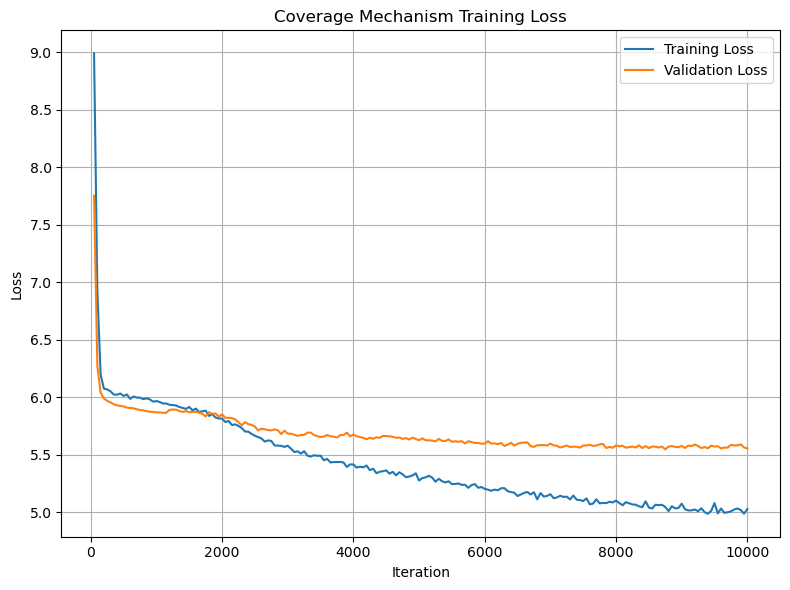

In [38]:
# === Model Setup ===
encoder_coverage = EncoderRNNWithCoverage(
    input_size=len(input_vocab),
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=0.3
).to(device)

decoder_coverage = CoverageDecoderRNN(
    output_size=len(output_vocab),
    emb_dim=EMB_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout=0.3
).to(device)

model_coverage = Seq2SeqCoverageModel(encoder_coverage, decoder_coverage, device).to(device)

# === Optimizer & Loss ===
optimizer_cov = torch.optim.Adam(model_coverage.parameters(), lr=0.0001, weight_decay=1e-5)
criterion_cov = nn.CrossEntropyLoss(ignore_index=output_vocab[PAD_TOKEN])

# === Train ===
train_model(
    model=model_coverage,
    train_loader=train_loader,
    val_loader=dev_loader,
    optimizer=optimizer_cov,
    criterion=criterion_cov,
    output_vocab=output_vocab,
    device=device,
    num_iters=num_iters,
    print_every=print_every,
    plot_every=plot_every,
    teacher_forcing_ratio=0.6,
    log_filename="CoverageModel_log.csv",
    plot_title="Coverage Mechanism Training Loss"
)

#### Testing the model 

In [39]:
# Make sure model is in evaluation mode
model_coverage.eval()
Spicy2_preds = []

for i in range(len(test_df)):
    ingredients_coverage = test_df.iloc[i]['Ingredients']

    # 🔁 Join ingredients list to a string, then preprocess
    if isinstance(ingredients_coverage, list):
        ingredients = " ".join(ingredients_coverage)

    tokens_coverage = preprocess_text(ingredients_coverage)
    input_ids_coverage = [input_vocab.get(tok, input_vocab[UNK_TOKEN]) for tok in tokens_coverage]
    input_ids_coverage = input_ids_coverage[:MAX_INGREDIENT_LEN] + [input_vocab[PAD_TOKEN]] * max(0, MAX_INGREDIENT_LEN - len(input_ids_coverage))

    src_tensor_coverage = torch.tensor(input_ids_coverage, dtype=torch.long, device=device)

    # 🧠 Generate recipe
    generated_recipe_coverage = generate_recipe_Coverage(model_coverage, src_tensor_coverage, output_vocab, device)
    Spicy2_preds.append(generated_recipe_coverage)

# 🗂️ Add predictions to DataFrame
test_df['Recipe - Spicy 2'] = Spicy2_preds

# ✅ Choose columns
columns_to_save_2 = ['Ingredients', 'Recipe - Spicy 2']
if 'Recipe' in test_df.columns:
    columns_to_save_2.insert(1, 'Recipe')

# 💾 Save to timestamped CSV
filename_2 = "Spicy2_output.csv"
test_df[columns_to_save_2].to_csv(filename_2, index=False)
print(f"✅ Spicy2 predictions saved to {filename_2}")

✅ Spicy2 predictions saved to Spicy2_output.csv


#### Evalating the result

In [41]:
# Step 1: Evaluate your attention model
metrics_coverage = evaluate_model(
    model_coverage,
    test_loader,
    input_vocab,
    output_vocab,
    device,
    model_name="Coverage mechanism"
)

# Step 2: Load existing results if the file exists
results_file = "Assignment_2_evaluation_results.csv"
if os.path.exists(results_file):
    results_df = pd.read_csv(results_file)
    results_df = pd.concat([results_df, pd.DataFrame([metrics_coverage])], ignore_index=True)
else:
    results_df = pd.DataFrame([metrics_coverage])

# Step 3: Save back to the same file
results_df.to_csv(results_file, index=False)

print(f"✅ Appended results to {results_file}")
print(results_df.tail(1))  # show just the latest entry

Evaluating: 100%|██████████| 1081/1081 [01:02<00:00, 17.18it/s]
/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Appended results to Assignment_2_evaluation_results.csv
                Model      BLEU    METEOR BERTScore
9  Coverage mechanism  0.017502  0.098239   0.80841


### Toy Input texts (gold and predicted recipes)

In [42]:
def predict_recipe_from_input(model, input_text, input_vocab, output_vocab, device,
                              preprocess_fn=preprocess_text,
                              max_input_len=MAX_INGREDIENT_LEN,
                              max_output_len=MAX_RECIPE_LEN,
                              use_attention=False):
    """
    Generate a recipe from an input ingredient list using the provided model.
    
    Args:
        model: Trained Seq2Seq model.
        input_text: Raw ingredient string.
        input_vocab: Dictionary mapping input tokens to indices.
        output_vocab: Dictionary mapping output indices to tokens.
        device: Device to run the model on (CPU or GPU).
        preprocess_fn: Preprocessing function used during training.
        max_input_len: Maximum length of input sequence.
        max_output_len: Maximum length of output recipe.
        use_attention: Whether the model uses attention.

    Returns:
        Generated recipe string.
    """
    model.eval()
    tokens = preprocess_fn(input_text)
    input_ids = [input_vocab.get(tok, input_vocab[UNK_TOKEN]) for tok in tokens]
    input_ids = input_ids[:max_input_len] + [input_vocab[PAD_TOKEN]] * max(0, max_input_len - len(input_ids))

    src_tensor = torch.tensor(input_ids, dtype=torch.long, device=device)

    with torch.no_grad():
        generated_recipe = generate_recipe(model, src_tensor, output_vocab, device,
                                           max_len=max_output_len,
                                           use_attention=use_attention)
    return generated_recipe

In [ ]:
# Example input
user_input = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"

output_recipe_attention = predict_recipe_from_input(
    model= model_coverage, 
    input_text=user_input,
    input_vocab=input_vocab,
    output_vocab=output_vocab,
    device=device,
    use_attention= False # or True if the model uses attention
)
print("🧾 Generated Recipe model coverage:\n", output_recipe_attention)

🧾 Generated Recipe Set RNN:
 mix ingredient together add cup sugar water add sugar salt pepper add add vanilla add vanilla pour mixture mixture pan chill hour
🧾 Generated Recipe model coverage:
 mix ingredient together add ginger ale


In [ ]:
# Example input
user_input = "8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"


output_recipe_attention = predict_recipe_from_input(
    model= model_coverage, 
    input_text=user_input,
    input_vocab=input_vocab,
    output_vocab=output_vocab,
    device=device,
    use_attention= False  # or True if the model uses attention
)
print("🧾 Generated Recipe model coverage:\n", output_recipe_attention)

🧾 Generated Recipe Set RNN:
 mix ingredient together add cup sugar add milk mixture add vanilla stir well add vanilla pour mixture mixture pan chill hour
🧾 Generated Recipe model coverage:
 mix cream cheese sugar cream cheese sugar add cream cheese add cream cheese fold whipped cream cheese mixture chill
